In [3]:
import pandas as pd

df = pd.read_csv("../data/raw/hotel_bookings.csv")
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [4]:
import seaborn as sns

In [5]:
import matplotlib.pyplot as plt

In [6]:
df.shape
df.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date'],
      dtype='object')

# Model przewiduje, czy rezerwacja zostanie anulowana, na podstawie informacji znanych w momencie jej dokonania.

In [7]:
target_col = "is_canceled"

In [8]:
leakage_cols = [
    "reservation_status",
    "reservation_status_date"
]

## Te kolumny zawierają informację po fakcie.

In [9]:
df = df.drop(columns=leakage_cols)

## Kolumny problematyczne

In [10]:
df = df.drop(columns=["agent", "company"])

In [11]:
df = df.drop(columns=["country"])

## Ustalany po rezerwacji

In [12]:
df = df.drop(columns=["assigned_room_type"])

In [13]:
df.isna().sum().sort_values(ascending=False).head(10)

children                       4
hotel                          0
distribution_channel           0
required_car_parking_spaces    0
adr                            0
customer_type                  0
days_in_waiting_list           0
deposit_type                   0
booking_changes                0
reserved_room_type             0
dtype: int64

In [14]:
empty_rows = df.isna().all(axis=1).sum()
empty_rows

np.int64(0)

### Mimo wykrycia dużej liczby zduplikowanych wierszy, rekordy te zostały zachowane.
Zbiór danych nie zawiera unikalnego identyfikatora rezerwacji, a identyczne wartości cech mogą w uzasadniony sposób odpowiadać różnym zdarzeniom rezerwacji.
Usunięcie takich rekordów mogłoby zakłócić dystrybucję danych bazowych.

In [15]:
df.duplicated().sum()

np.int64(35142)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 26 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

### Zbiór danych jest umiarkowanie niezrównoważony

In [17]:
df[target_col].value_counts(normalize=True)

is_canceled
0    0.629584
1    0.370416
Name: proportion, dtype: float64

### Rezerwacje anulowane mają znacznie dłuższy lead time.

<Axes: xlabel='is_canceled'>

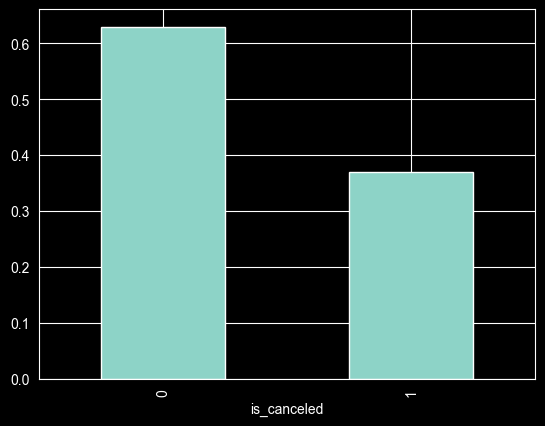

In [18]:
df["is_canceled"].value_counts(normalize=True).plot(kind="bar")

In [19]:
df.groupby(target_col)["lead_time"].median()

is_canceled
0     45.0
1    113.0
Name: lead_time, dtype: float64

### Klienci z historią anulacji mają znacznie wyższe ryzyko kolejnej anulacji.

In [20]:
pd.crosstab(
    df["previous_cancellations"],
    df[target_col],
    normalize="index"
)

is_canceled,0,1
previous_cancellations,,
0,0.660939,0.339061
1,0.055693,0.944307
2,0.672414,0.327586
3,0.692308,0.307692
4,0.774194,0.225806
5,0.894737,0.105263
6,0.681818,0.318182
11,0.714286,0.285714
13,0.083333,0.916667


In [21]:
df.isna().mean().sort_values(ascending=False).head(10)

children                       0.000034
hotel                          0.000000
distribution_channel           0.000000
required_car_parking_spaces    0.000000
adr                            0.000000
customer_type                  0.000000
days_in_waiting_list           0.000000
deposit_type                   0.000000
booking_changes                0.000000
reserved_room_type             0.000000
dtype: float64

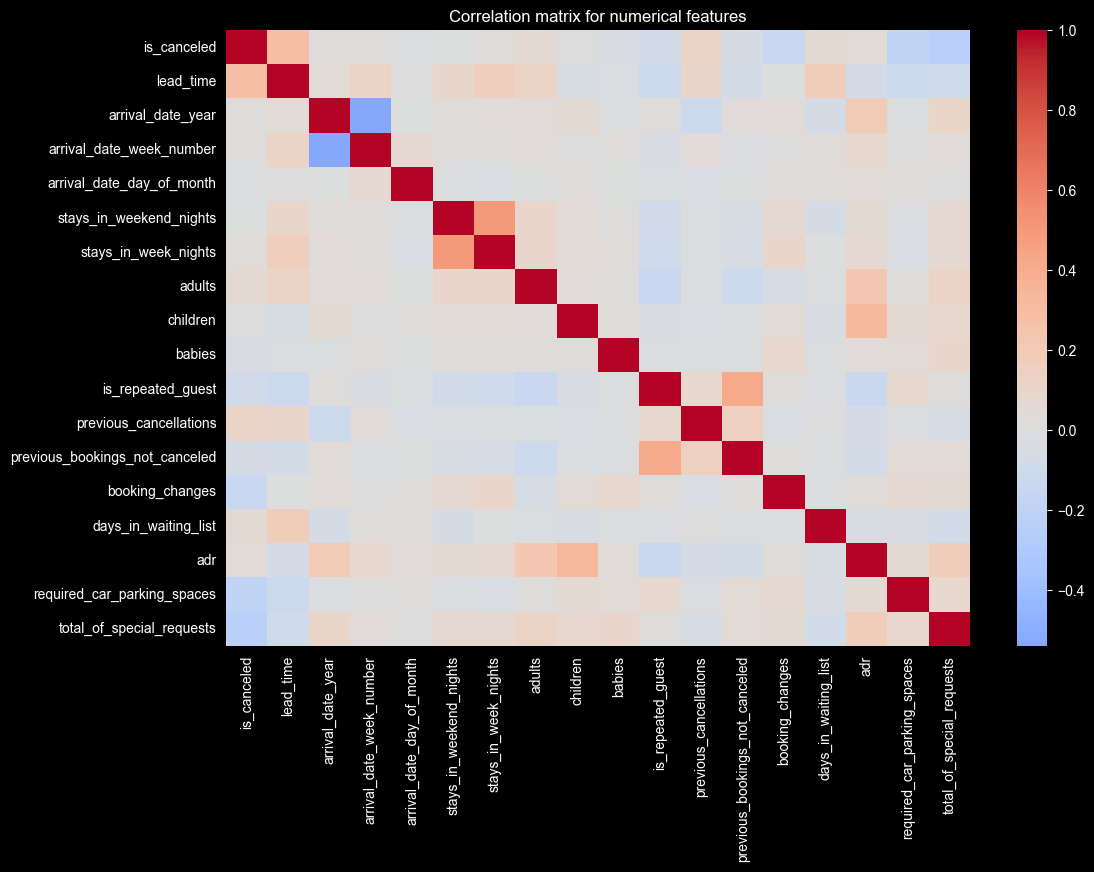

In [22]:
num_cols = df.select_dtypes(include=["int64", "float64"]).columns

corr = df[num_cols].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Correlation matrix for numerical features")
plt.show()

In [23]:
df["total_nights"] = (
    df["stays_in_week_nights"] + df["stays_in_weekend_nights"]
)

df = df.drop(columns=[
    "stays_in_week_nights",
    "stays_in_weekend_nights"
])

In [24]:
df = df.drop(columns=["is_repeated_guest"])

In [25]:
num_cols = df.select_dtypes(include=["int64", "float64"]).columns

corr_with_target = (
    df[num_cols]
    .corrwith(df["is_canceled"])
    .sort_values()
)

corr_with_target

total_of_special_requests        -0.234658
required_car_parking_spaces      -0.195498
booking_changes                  -0.144381
previous_bookings_not_canceled   -0.057358
babies                           -0.032491
arrival_date_day_of_month        -0.006130
children                          0.005048
arrival_date_week_number          0.008148
arrival_date_year                 0.016660
total_nights                      0.017779
adr                               0.047557
days_in_waiting_list              0.054186
adults                            0.060017
previous_cancellations            0.110133
lead_time                         0.293123
is_canceled                       1.000000
dtype: float64

In [26]:
corr_with_target.tail(5)

days_in_waiting_list      0.054186
adults                    0.060017
previous_cancellations    0.110133
lead_time                 0.293123
is_canceled               1.000000
dtype: float64

In [27]:
corr_with_target.head(5)

total_of_special_requests        -0.234658
required_car_parking_spaces      -0.195498
booking_changes                  -0.144381
previous_bookings_not_canceled   -0.057358
babies                           -0.032491
dtype: float64

In [28]:
df["has_previous_cancellations"] = (
    df["previous_cancellations"] > 0
).astype(int)

In [29]:
df = df.drop(columns=["previous_cancellations"])

In [30]:
df = df.drop(columns=["required_car_parking_spaces"])

In [32]:
df.to_csv(
    "../data/processed/hotel_bookings_clean.csv",
    index=False
)